# EEG Seizure Classification with Machine Learning
### The Bonn EEG Time Series
The dataset was first published:
>Andrzejak, R. G., Lehnertz, K., Mormann, F., Rieke, C., David, P., & Elger, C. E. (2001). Indications of nonlinear deterministic and finite-dimensional structures in time series of brain electrical activity: Dependence on recording region and brain state. Physical Review. E, Statistical Physics, Plasmas, Fluids, and Related Interdisciplinary Topics, 64(6). https://doi.org/10.1103/physreve.64.061907

>The data download page:
https://www.upf.edu/web/ntsa/downloads/-/asset_publisher/xvT6E4pczrBw/content/2001-indications-of-nonlinear-deterministic-and-finite-dimensional-structures-in-time-series-of-brain-electrical-activity-dependence-on-recording-regi

Data Files:
For each set (A-E) there is a ZIP-file containing 100 TXT-files. Each TXT-file consists of 4097 samples of one EEG time series in ASCII code.

1. SET A in file  Z.zip  containing Z000.txt - Z100.txt
2. SET B in file  O.zip containing O000.txt - O100.txt
3. SET C in file  N.zip containing N000.txt - N100.txt
4. SET D in file  F.zip containing F000.txt - F100.txt
5. SET E in file  S.zip containing S000.txt - S100.txt
---
### Dataset Description
The dataset consists of **five subsets (Sets A–E)** where each set consists of **100 single channel EEG records**. Each of these records have been recorded for a duration of **23.6 seconds** at a sampling rate of 173.61 Hz with 12 bit ADC resolution. Each segment contains **4097 unfiltered samples**. The data are anonymized and randomized with respect to subjects and electrode contacts.

1. **SET A [Z]** extracranially - relaxed state of **5 healthy subjects** with eyes closed
2. **SET B [O]** extracranially - relaxed state of **5 healthy subjects** with eyes opened
3. **SET C [N]** intracranially - during a seizure free interval (inter-ictal period); **5 patients**; recorded from non-epileptogenic zone (opposite hippocampus)
4. **SET D [F]** intracranially - during a seizure free interval (inter-ictal period); **5 patients**; recorded from within the epileptogenic zone
5. **SET E [S]** intracranially - during epileptic seizures (ictal period); **5 patients**
---
## Exploratory Data Analysis
### Part-1 Data Overview
#### Understand the Dataset
- There are five subset folder (Sets A-E) stored in the data folder and represent five groups of data described above.
- Each folder contains 100 txt files, representing the 100 single channel EEG segments
- The time duration for each segment is 23.6 seconds at a sampling rate of 173.61 Hz
- 23.6s * 173.61 Hz ≈ 4097 samples
- So, the final sample number in each file/segment is 4097 (Sample N=4097)
- 4097 = time points sampled from a 23.6-second EEG segment

#### What does your data look like?
Taking SET A/ Folder Z as an example, I display the first 5 files from this folder, each file represent a single channel EEG record.
- x-axis is the 4097 time points labels as "Time (Sample Index)"
- y-axis is the EEG signal amplitude, typically measured in microvolts (µV), which is the raw values of brain electrical activity.

#### What's the data size?
5 folders; each folder contains 100 txt files; each file contains 4097 rows 1 column

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import glob

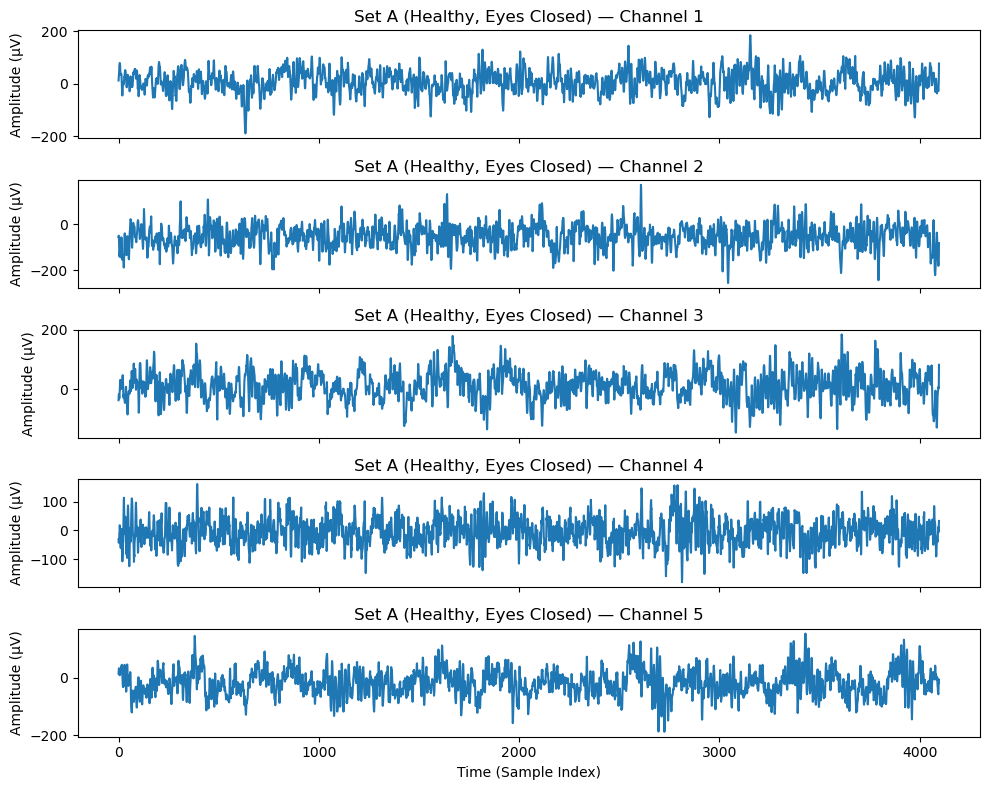

In [2]:
# Load first 5 EEG signal files from Set A (folder 'Z')
eeg_files = sorted(glob.glob("data/Z/Z0*.txt"))[:5]

# Create a figure with subplots to visualize each EEG signal channel record
fig, axs = plt.subplots(len(eeg_files), 1, figsize=(10, 8), sharex=True)

for i, file_path in enumerate(eeg_files):
    # Load EEG signal into a 1D Series
    signal = pd.read_csv(file_path, header=None).squeeze("columns")

    # Plot the signal
    axs[i].plot(signal.values)

    # Labeling each subplot
    channel_number = i + 1
    axs[i].set_title(f"Set A (Healthy, Eyes Closed) — Channel {channel_number}")
    axs[i].set_ylabel("Amplitude (µV)")

# X-axis shared across all plots
plt.xlabel("Time (Sample Index)")
plt.tight_layout()
plt.show()

### Part-2 Data Labeling and Loading
### Folder Selection
In this study, I focus specifically on **Sets A, D, and E** from the Bonn EEG dataset. These three subsets were explicitly selected in the previous Random Forest paper using the same Bonn dataset to evaluate the performance of the proposed seizure classification methodology.
>EEG signal analysis for Seizure detection using Discrete Wavelet Transform and Random Forest. (n.d.). IEEE Conference Publication | IEEE Xplore. https://ieeexplore.ieee.org/document/8079760

---
My objective for this project is to replicate the original methodology using DWT and Random Forests, and to **extend the analysis** by applying and comparing alternative classification models covered in our course, such as:
- Logistic Regression Classification
- Support Vector Machine (SVM)
- (Optionally) Linear Regression to test its applicability in a classification setting

This comparative modeling will help evaluate how **linear vs. non-linear** algorithms perform on EEG-based seizure detection tasks using features derived from DWT-Hilbert-transformed subbands.

---
 The rationale for selecting these sets is grounded in the clinical relevance (argued by previous RF paper):
1. Set A: Contains EEG signals from healthy volunteers recorded with eyes closed. These serve as non-pathological baseline data representing normal brain activity.
2. Set D: Includes EEG recordings from epileptic patients during seizure-free (inter-ictal) periods, specifically from the epileptogenic zone. These signals reflect the brain’s activity in between seizures and are critical for identifying pre-seizure patterns.
3. Set E: Comprises EEG segments recorded during active seizure episodes (ictal periods). These provide direct examples of epileptic activity.

---
### Data Loading
To prepare the dataset for analysis, I perform the following steps in this section:
- Reading all .txt files from folders Z, F, S
- Assigning labels and descriptions based on which set/folder the file is from
- Creating a structured DataFrame (eeg_df) that contains: filename; set; label; description; signal (4097 samples)

In [3]:
# Define the mapping of folder to labels and descriptions
set_map = {
    'Z': {'label': 0, 'desc': 'Set A — Eyes Closed'},
    'F': {'label': 1, 'desc': 'Set D — Inter-ictal Period'},
    'S': {'label': 2, 'desc': 'Set E — Ictal Period'}
}

# Initialize list to store all EEG records
eeg_records = []

# Loop through each set and load the corresponding EEG files
for set_folder, info in set_map.items():
    folder_path = f"data/{set_folder}"
    file_paths = sorted(glob.glob(os.path.join(folder_path, "*.txt")))

    for file_path in file_paths:
        try:
            # Load the signal into a pandas Series (1D)
            signal = pd.read_csv(file_path, header=None).squeeze("columns")

            # Check if signal has the correct number of samples (4097)
            if len(signal) != 4097:
                print(f"Warning: Skipped {file_path}, length = {len(signal)}")
                continue

            # Append metadata and signal to the record list
            eeg_records.append({
                'filename': os.path.basename(file_path),
                'set': set_folder,
                'label': info['label'],
                'description': info['desc'],
                'signal': signal
            })
        except Exception as e:
            print(f"Error loading {file_path}: {e}")

# Convert to a DataFrame
eeg_df = pd.DataFrame(eeg_records)
eeg_df.head()

,filename,set,label,description,signal
0,Z001.txt,Z,0,Set A — Eyes Closed,0 12 1 22 2 35 3 45 4 ...
1,Z002.txt,Z,0,Set A — Eyes Closed,0 -56 1 -50 2 -64 3 -9...
2,Z003.txt,Z,0,Set A — Eyes Closed,0 -37 1 -22 2 -17 3 -24 4 ...
3,Z004.txt,Z,0,Set A — Eyes Closed,0 -31 1 -43 2 -39 3 -39 4 ...
4,Z005.txt,Z,0,Set A — Eyes Closed,0 14 1 26 2 32 3 25 4 ...


In [4]:
eeg_df.shape

(300, 5)

In [5]:
# Check data type of the signal column
type(eeg_df.loc[0, 'signal'])

# Print first few signal values for a specific row
print(eeg_df.loc[0, 'signal'].head(10))

# Check length of one signal
len(eeg_df.loc[0, 'signal'])  # Should return 4097

0    12
1    22
2    35
3    45
4    69
5    74
6    79
7    78
8    66
9    43
Name: 0, dtype: int64


4097

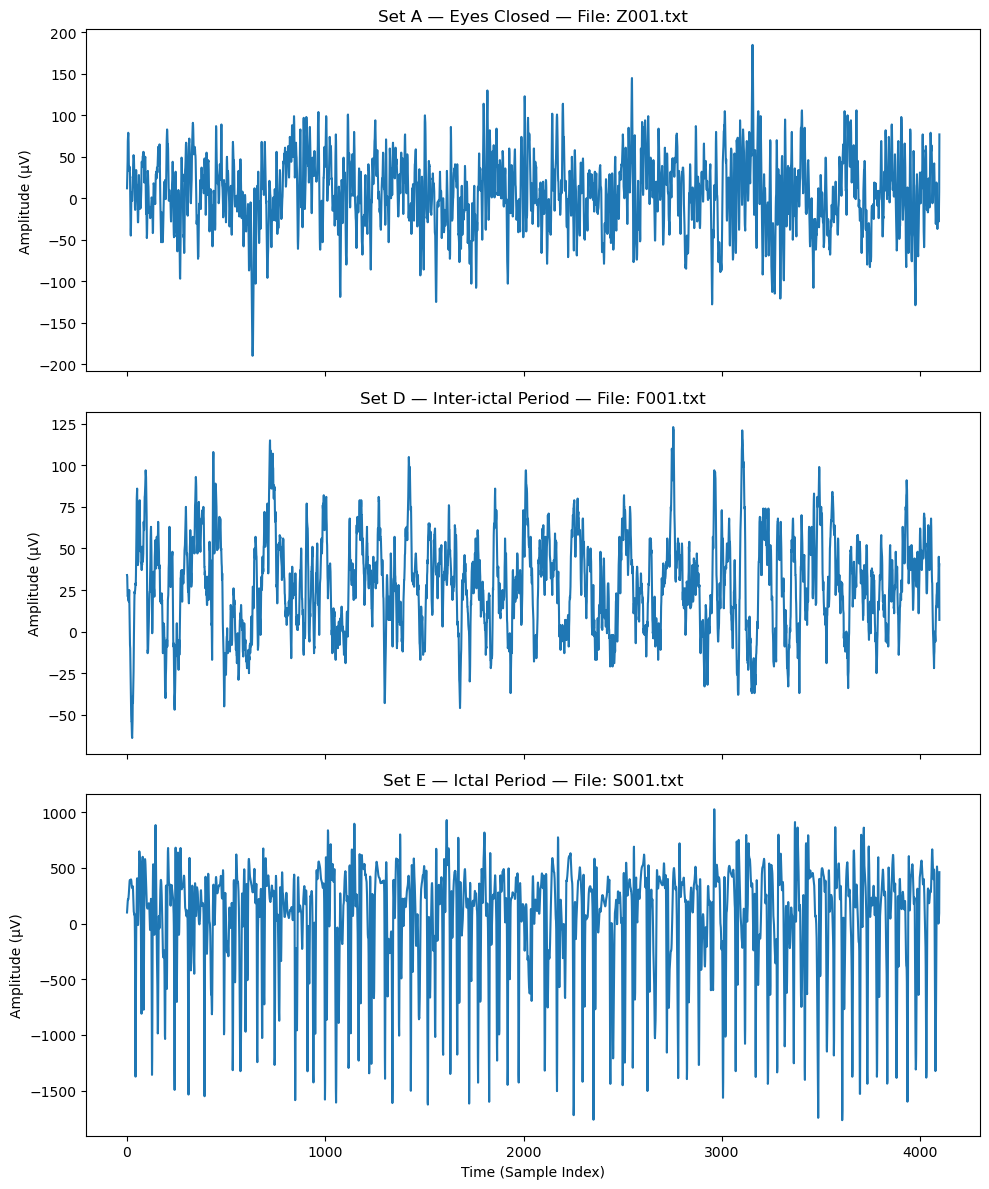

In [6]:
# Visualization of the 1st EEG channel from each set
# Define desired plotting order
ordered_keys = ['Z','F', 'S']

fig, axs = plt.subplots(len(ordered_keys), 1, figsize=(10, 12), sharex=True)

for i, set_folder in enumerate(ordered_keys):
    subset = eeg_df[eeg_df['set'] == set_folder]

    first_row = subset.iloc[0]
    signal = first_row['signal']
    desc = first_row['description']
    fname = first_row['filename']

    axs[i].plot(signal.values)
    axs[i].set_title(f"{desc} — File: {fname}")
    axs[i].set_ylabel("Amplitude (µV)")

plt.xlabel("Time (Sample Index)")
plt.tight_layout()
plt.show()

### Part-3 Data Cleaning
- Checking missing value
- There is no missing value in this dataset
#### Outlier Detection
- For this EEG dataset, outlier removal may remove true epileptic patterns so I choose not to use outlier detection
- No IQR statistics used

In [7]:
# Check the missing values, true for NaN, sum() for counting missing values per column, any() to check if any missing value exists
null_sum = eeg_df.isnull().sum()
null_sum # No missing value so no data cleaning needed

filename       0
set            0
label          0
description    0
signal         0
dtype: int64

### Part-4 Data Preprocessing
#### 1. Discrete Wavelet Transform (DWT) Decomposition
The EEG signals provided in the Bonn dataset are **raw and unfiltered**. While the original paper briefly mentioned a **low-pass filter at 40 Hz**, the Random Forest paper chose instead to use a **Discrete Wavelet Transform (DWT)** as the primary signal decomposition technique, especially given that seizure EEG signals are **non-stationary and non-linear** in nature.

In this preprocessing step, I replicate the DWT-based approach described in the Random Forest article, which involves:
- Using the **Daubechies 6 (db6)** wavelet function.
- Decomposing each EEG signal using **5 levels** of wavelet transformation.
- Producing **six subband components**:
  - `cA5` — Approximation coefficient from level 5 (captures low-frequency trends).
  - `cD1` to `cD5` — Detail coefficients from each level (capture high-frequency components at varying resolutions).
---
#### DWT Overview
The Discrete Wavelet Transform (DWT) decomposes a time-domain signal into frequency-localized subbands using two filtering paths:
- **High-pass filter `g[n]`**: captures rapid changes and high-frequency detail (producing detail coefficients `cD`).
- **Low-pass filter `h[n]`**: captures slower variations and low-frequency structure (producing approximation coefficients `cA`).
---
#### Preprocessing Notes

- The implementation of DWT follows an open-source tutorial available here:
 >https://github.com/Western-OC2-Lab/Signal-Processing-for-Machine-Learning/blob/main/Discrete%20Wavelet%20Transform%20(DWT).ipynb

- **Normalization before DWT**:
  Although the original Random Forest article does not explicitly mention normalization, many signal processing guidelines recommend applying **zero-mean normalization** to the signal before wavelet decomposition. This ensures that the resulting wavelet coefficients reflect relative variations rather than absolute amplitude shifts.
  > In this analysis, each EEG signal is normalized by subtracting its mean before applying DWT


In [8]:
import pywt
import numpy as np

In [9]:
# Apply DWT to all EEG signals and return full coefficient sets
def compute_dwt(df, wavelet='db6', levels=5):
    """
    Apply Discrete Wavelet Transform (DWT) to EEG signals using db6 wavelet.
    The DWT decomposes each signal into approximation (low-frequency)
    and detailed (high-frequency) components.

    Parameters:
    - df: pandas DataFrame with 'signal' column
    - wavelet: Wavelet function to use (default: 'db6')
    - levels: Number of decomposition levels (default: 5)

    Returns:
    - List of DWT coefficient sets (one per signal)
    """
    dwt_all = []
    for _, row in df.iterrows():
        signal = row['signal']
        signal = signal - np.mean(signal)  # Zero-mean normalization
        coeffs = pywt.wavedec(signal, wavelet=wavelet, level=levels)
        dwt_all.append(coeffs)
    return dwt_all

In [10]:
# Run DWT on the dataset (Only Set A, D, E used based on project goal)
eeg_df['dwt_coeffs'] = compute_dwt(eeg_df)

#### DWT Coefficient Selection for future Feature Extraction

As noted in the Random Forest article and EEG literature:
- EEG frequencies above **40 Hz** are not clinically relevant for epilepsy detection.
- Power-line noise (50–60 Hz) is also unwanted.

Thus, I extract only the following coefficients (same as the RF paper):
- **cA5** (approximation): Captures very low frequency
- **cD5**
- **cD4**
- **cD3**

These bands cover the frequency range where seizure-related activity is often found.


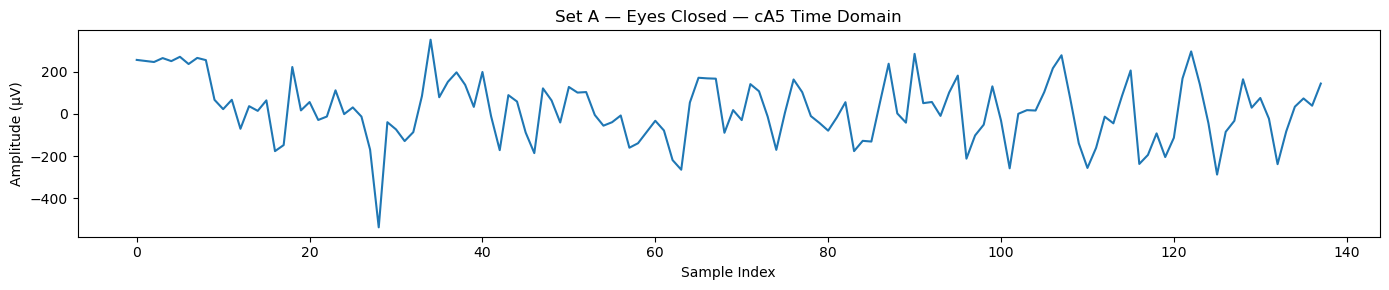

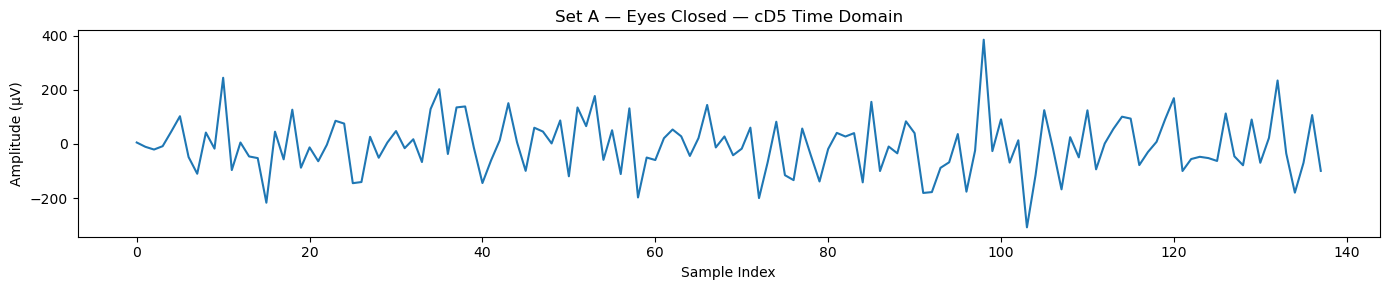

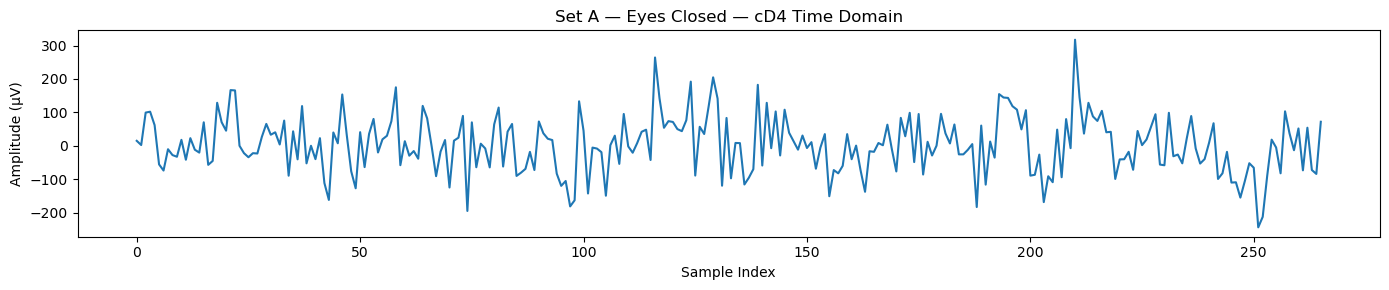

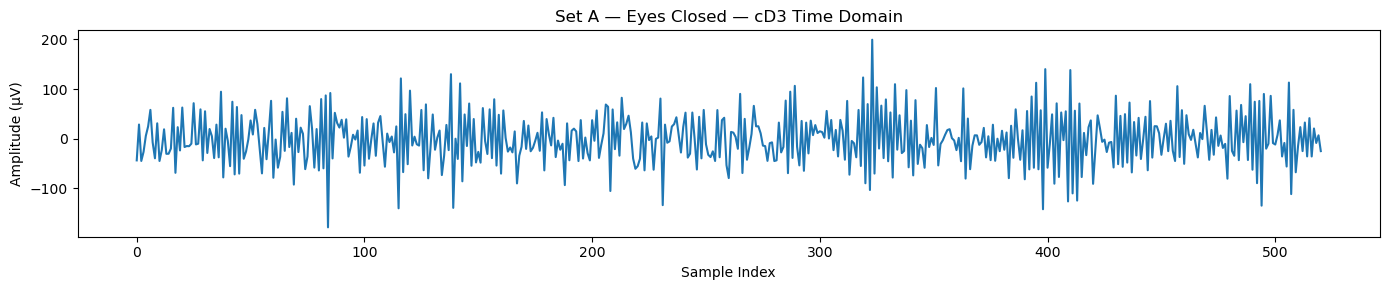

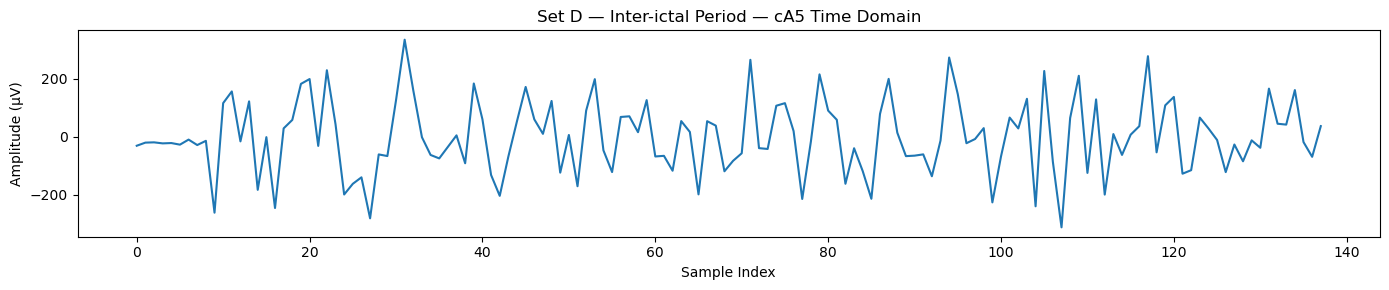

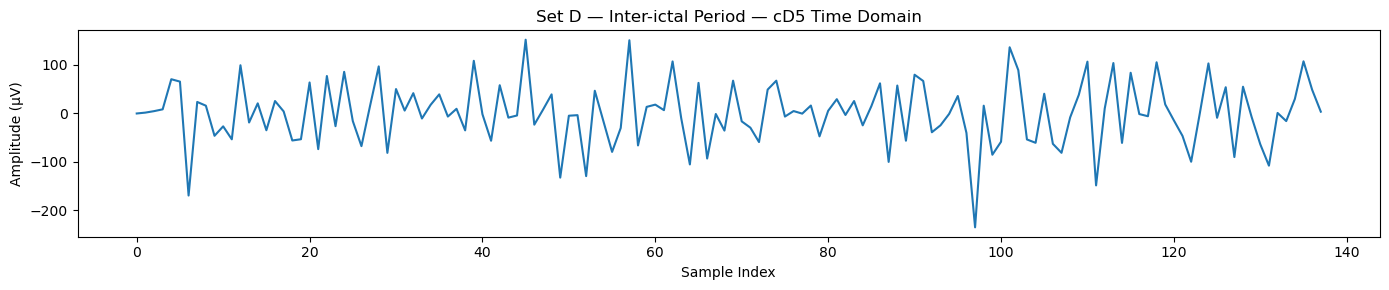

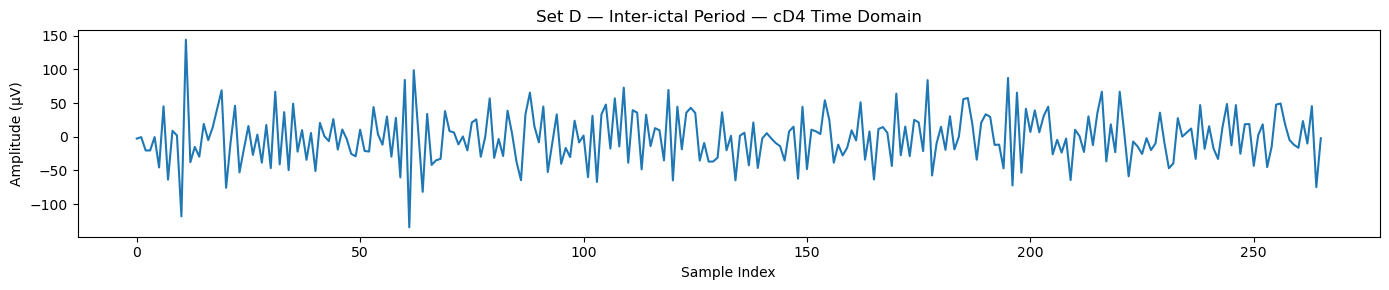

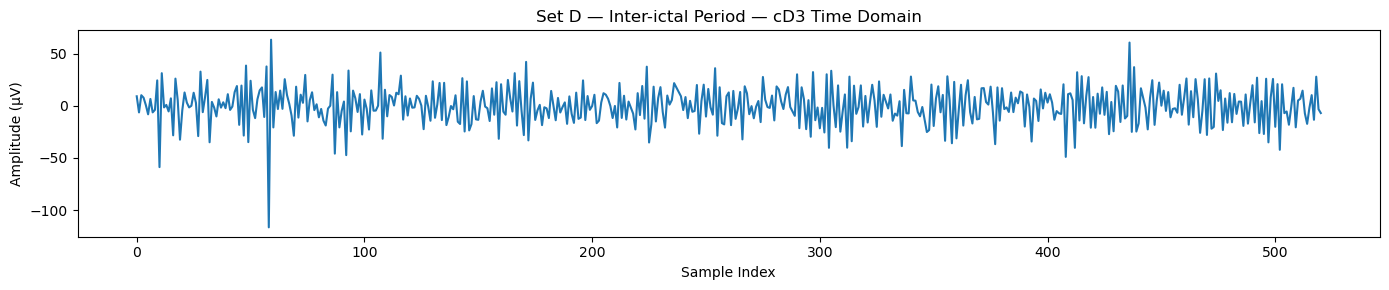

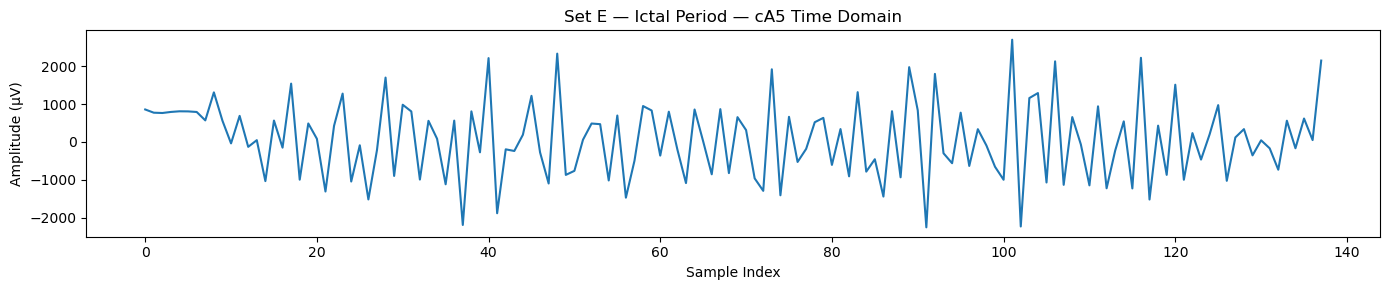

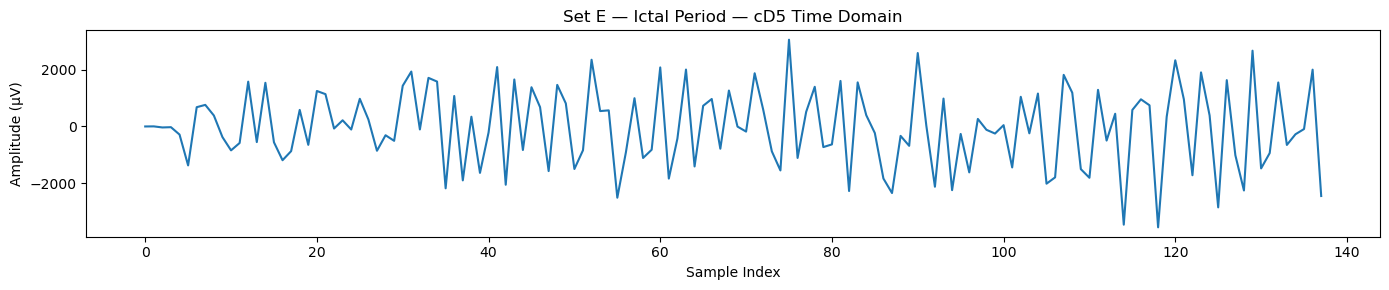

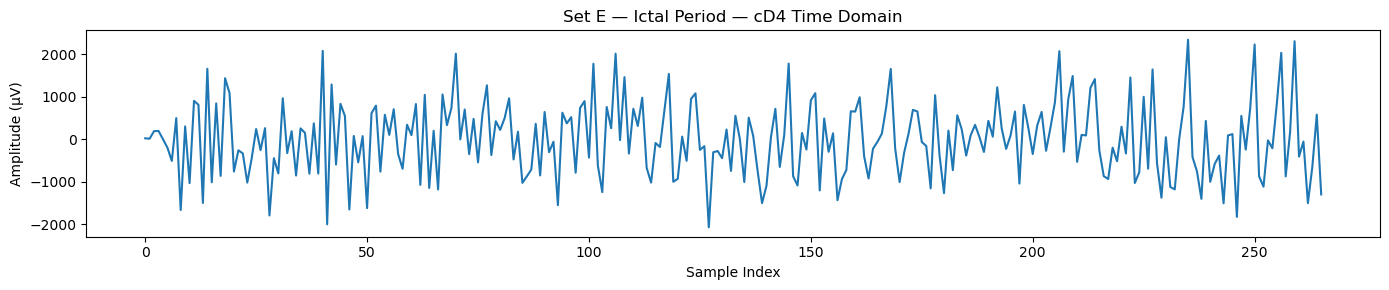

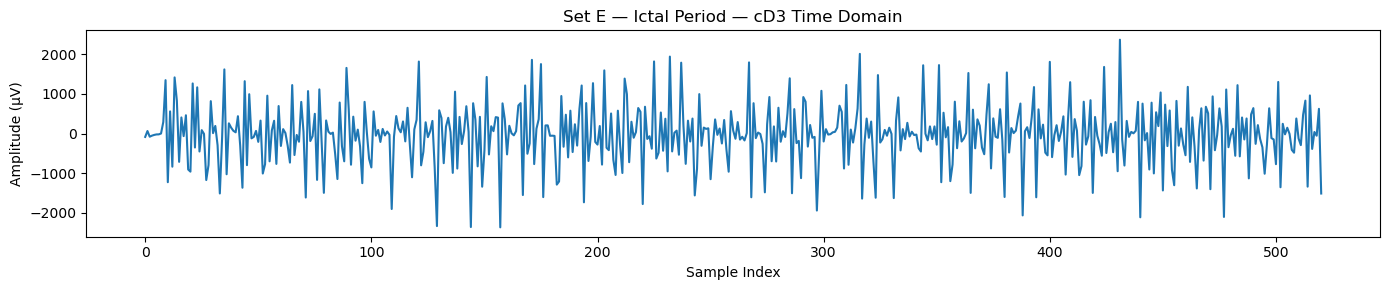

In [11]:
# Parameters
wavelet = 'db6'
levels = 5
fs = 173.61
nodes = ['cA5', 'cD5', 'cD4', 'cD3']
node_indices = [0, 1, 2, 3]

# Visualize one example from each class (Set A = 'Z', Set D = 'F', Set E = 'S')
for set_code in ['Z', 'F', 'S']:
    row = eeg_df[eeg_df['set'] == set_code].iloc[0]
    signal = row['signal'] - np.mean(row['signal'])  # Normalize again for clarity
    coeffs = pywt.wavedec(signal, wavelet=wavelet, level=levels)

    description = row['description']
    filename = row['filename']

    for i in node_indices:
        coef = coeffs[i]
        plt.figure(figsize=(14, 3))

        # Plot Time-Domain signal of selected coefficient
        plt.subplot(1, 1, 1)
        plt.plot(coef)
        plt.title(f"{description} — {nodes[i]} Time Domain")
        plt.xlabel("Sample Index")
        plt.ylabel("Amplitude (µV)")

        plt.tight_layout()
        plt.show()


#### 2. Hilbert Transform (HT) for Envelope Analysis
After decomposing EEG signals into frequency bands using Discrete Wavelet Transform (DWT), the next critical step is to extract the envelope spectrum of each subband. For this, I apply the Hilbert Transform (HT) following the method used in Random Forest paper.
>Similar to DWT, the Hilbert Transform is especially suited for analyzing nonlinear and non-stationary signals such as EEG, which traditional Fourier-based methods may not adequately capture.
> HT allows us to compute the envelope of each DWT subband, which represents smooth variations in energy over time.
> According to the original paper, HT improves the clarity of the subband signals, making patterns more interpretable and features more robust for machine learning.

The output envelope reflects how the energy in that frequency band fluctuates over time.


In [12]:
from scipy.signal import hilbert

In [13]:
# Define the selected wavelet subbands and their indices
selected_nodes = ['cA5', 'cD5', 'cD4', 'cD3']
selected_indices = [0, 1, 2, 3]  # indices in coeffs list for pywt.wavedec

In [14]:
# Function to compute Hilbert envelope for selected DWT subbands
def compute_ht_envelopes(df, wavelet='db6', levels=5):
    envelope_all = []  # To store results for each row

    for _, row in df.iterrows():
        signal = row['signal']
        signal = signal - np.mean(signal)  # Zero-mean normalization

        coeffs = pywt.wavedec(signal, wavelet=wavelet, level=levels)

        # Compute envelopes for selected subbands
        subband_envelopes = {}
        for name, i in zip(selected_nodes, selected_indices):
            coeff = coeffs[i]
            envelope = np.abs(hilbert(coeff))
            subband_envelopes[name] = envelope

        envelope_all.append(subband_envelopes)

    return envelope_all

In [15]:
# Apply the Hilbert envelope extraction to all rows in eeg_df
eeg_df['ht_envelopes'] = compute_ht_envelopes(eeg_df)

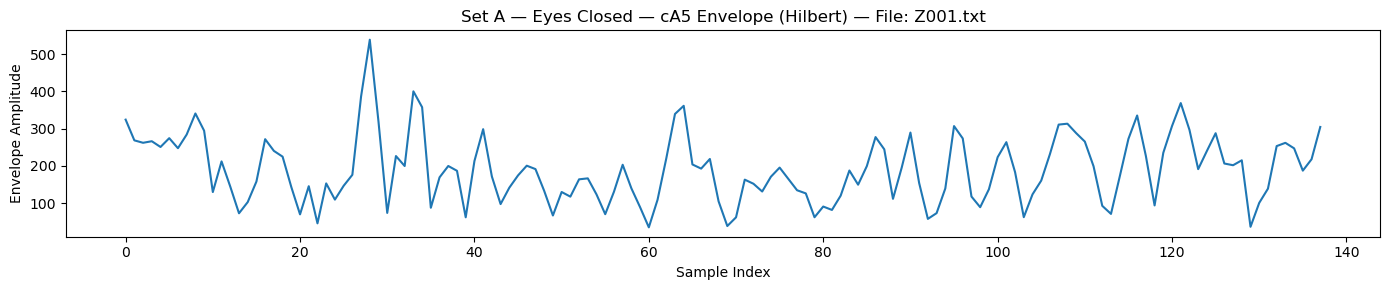

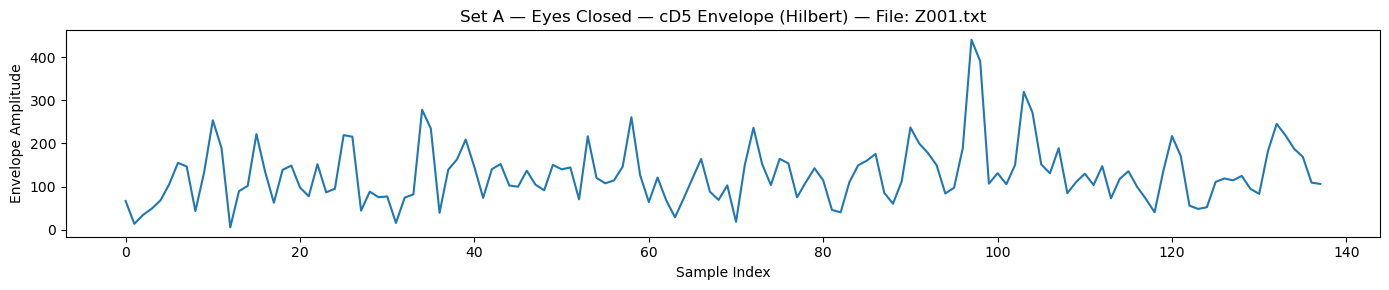

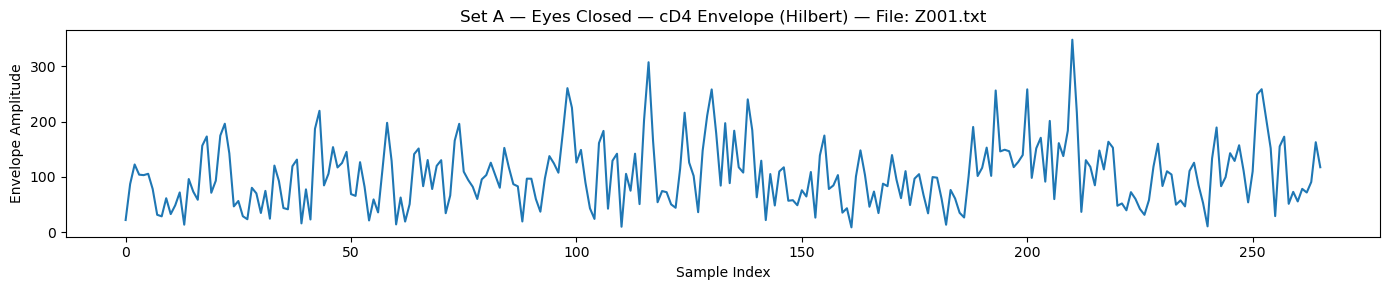

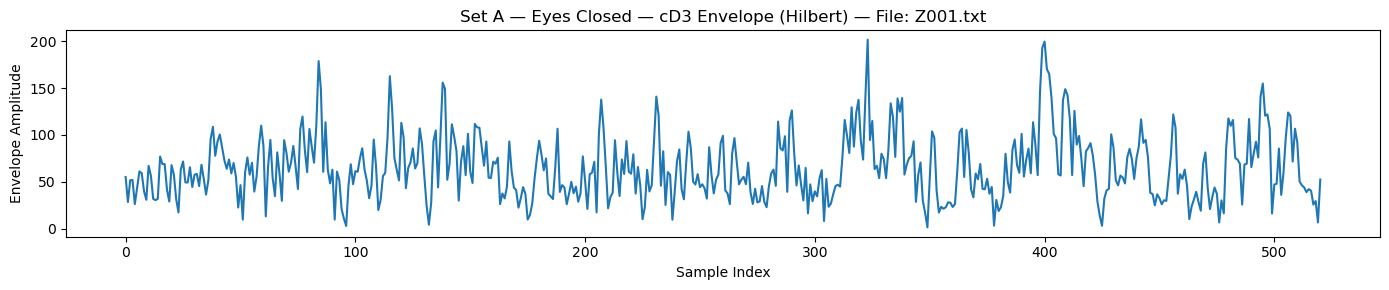

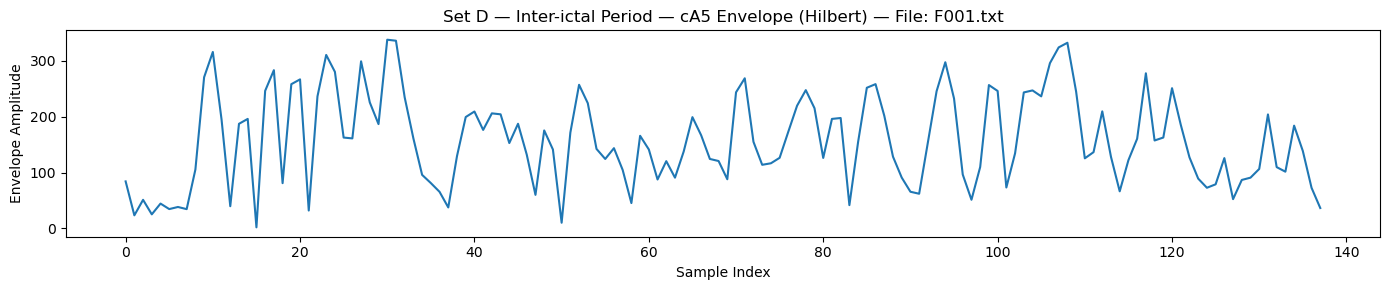

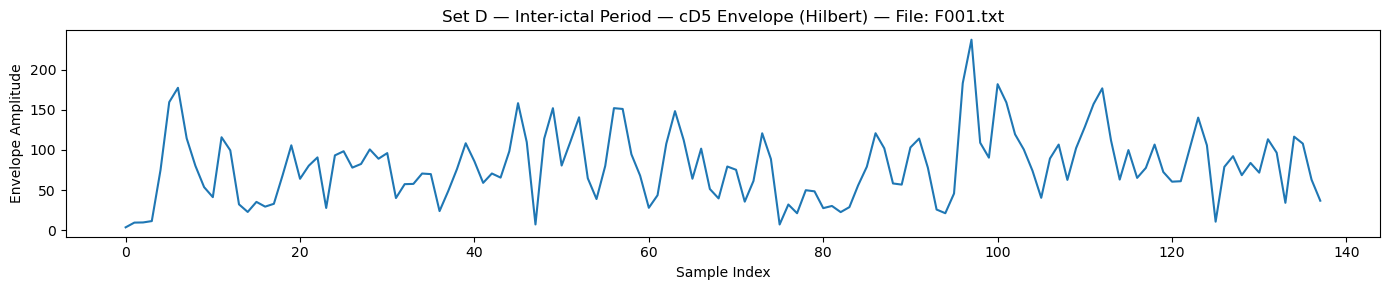

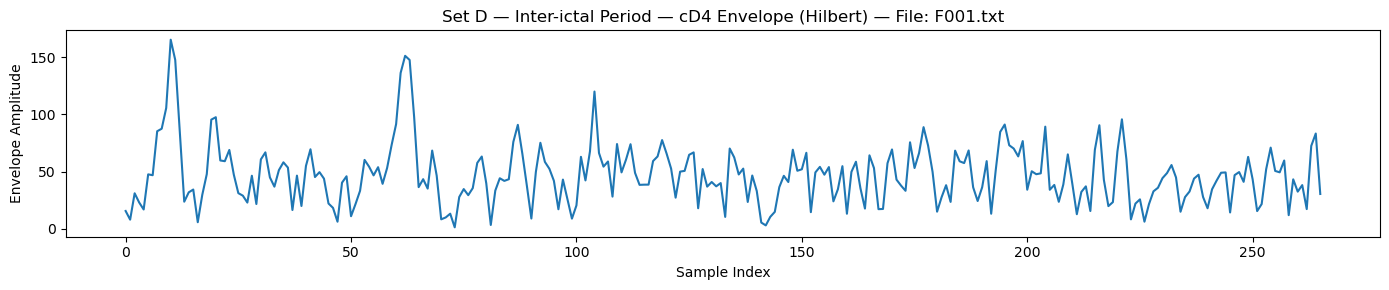

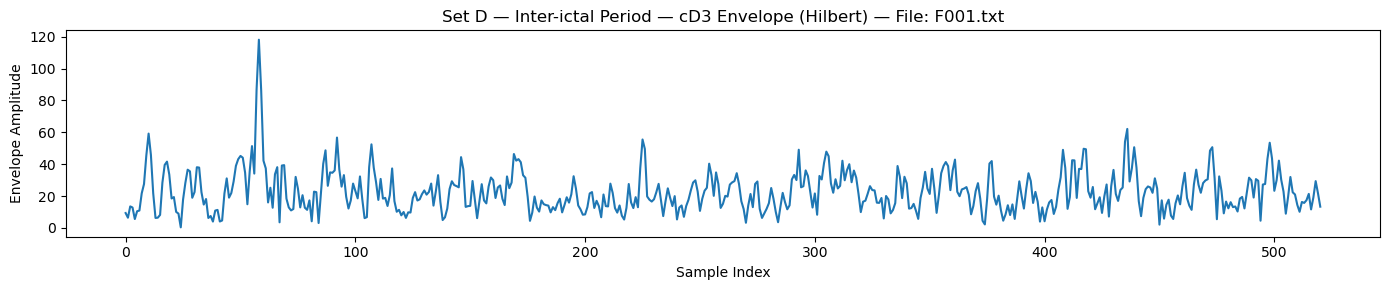

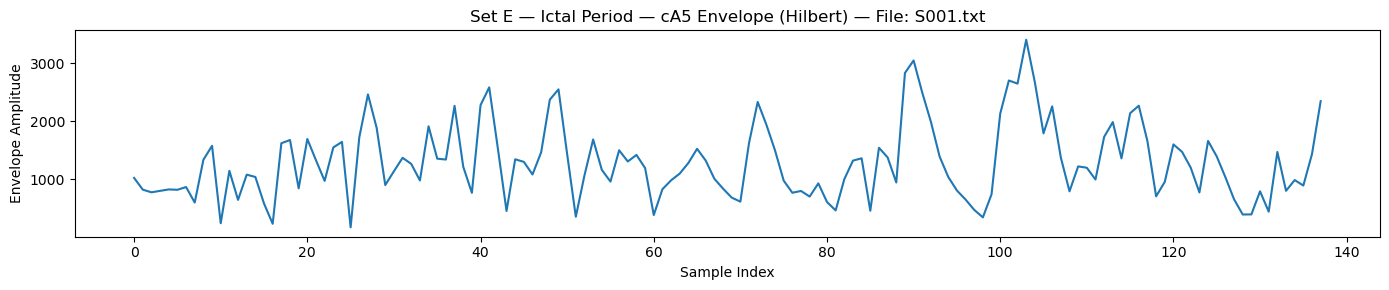

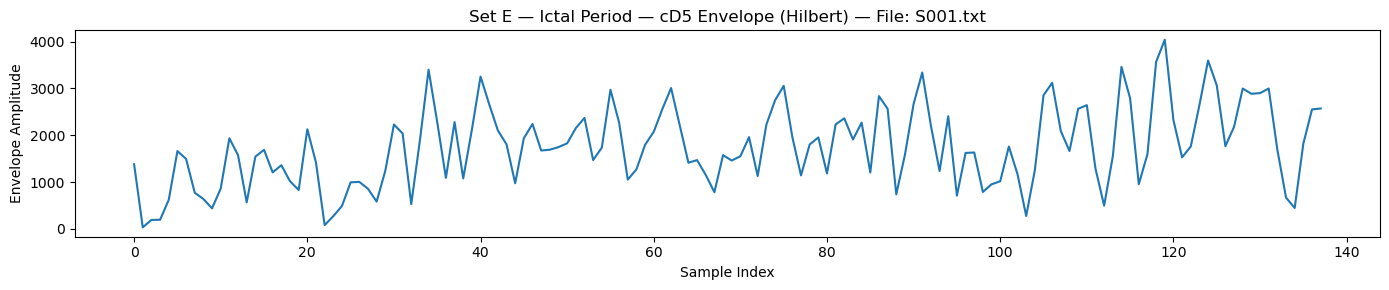

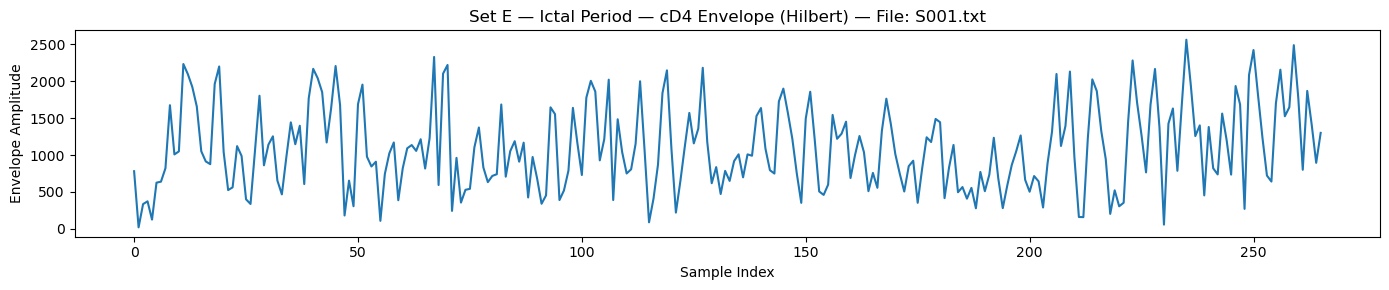

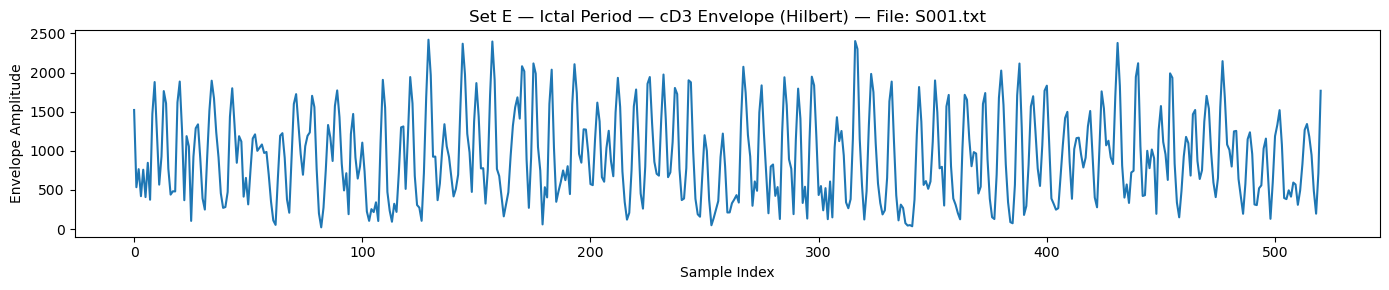

In [16]:
# Visualization: Plot envelopes of one file from each set (Z, F, S)
unique_sets = ['Z', 'F', 'S']

for set_code in unique_sets:
    row = eeg_df[eeg_df['set'] == set_code].iloc[0]
    envelopes = row['ht_envelopes']
    description = row['description']
    filename = row['filename']

    for name in selected_nodes:
        envelope = envelopes[name]

        plt.figure(figsize=(14, 3))
        plt.plot(envelope)
        plt.title(f"{description} — {name} Envelope (Hilbert) — File: {filename}")
        plt.xlabel("Sample Index")
        plt.ylabel("Envelope Amplitude")
        plt.tight_layout()
        plt.show()

In [17]:
eeg_df.head()

,filename,set,label,description,signal,dwt_coeffs,ht_envelopes
0,Z001.txt,Z,0,Set A — Eyes Closed,0 12 1 22 2 35 3 45 4 ...,"[[256.07409832998235, 250.99677926149025, 246....","{'cA5': [324.0785404369594, 268.42259932583494..."
1,Z002.txt,Z,0,Set A — Eyes Closed,0 -56 1 -50 2 -64 3 -9...,"[[-286.59502574577505, -262.22963991901867, -2...","{'cA5': [289.05726747261076, 269.6700376226093..."
2,Z003.txt,Z,0,Set A — Eyes Closed,0 -37 1 -22 2 -17 3 -24 4 ...,"[[-130.62025163507096, -151.39970205869867, -1...","{'cA5': [288.7621520831137, 169.11965297030576..."
3,Z004.txt,Z,0,Set A — Eyes Closed,0 -31 1 -43 2 -39 3 -39 4 ...,"[[-79.7921961905343, -85.04162929928854, -89.2...","{'cA5': [139.04047586049884, 94.89653968658081..."
4,Z005.txt,Z,0,Set A — Eyes Closed,0 14 1 26 2 32 3 25 4 ...,"[[200.30667642922648, 201.16089015594534, 202....","{'cA5': [271.9241705108092, 209.10905089753288..."


In [18]:
eeg_df.shape

(300, 7)

### Summary for Data Preprocessing
#### 1. What’s the Data Size? (After Preprocessing)
- The current dataset (eeg_df) consists of 300 rows × 7 columns.
- Each row corresponds to one EEG signal recording (4097 time points per signal).
- These recordings are taken from Set A (Z), Set D (F), and Set E (S) — 100 files per set.

#### 2. What’s Your Feature Space?
- 3 categorical: filename; set; label
- 1 text: description
- 3 numerical:
  - signal: array; raw EEG signal (length = 4097)
  - dwt_coeffs: list of arrays; 6 subband signals from DWT: cA5, cD5, ..., cD1
  - ht_envelopes: dict of arrays; envelope signals from cA5, cD5, cD4, cD3 using Hilbert Transform
    - 4 main numerical subband features per EEG signal
    - Each of these is a 1D array representing the signal envelope amplitude over time

#### 3. What is the Distribution of the Target Variable?
- Since this is a classification task, the target variable is label
- The classes are perfectly balanced (100 samples per class)

In [19]:
eeg_df['label'].value_counts().sort_index()

label
0    100
1    100
2    100
Name: count, dtype: int64

#### 4. Checking Distribution for EEG Dataset
- For EEG data, they don’t analyze the distribution of  raw signal values itself but care about the frequency content and amplitude variation in different subbands, by:
  - Decompose using DWT (frequency-aware)
  - Apply Hilbert Transform to get smooth envelopes
- The statistical distribution of these envelopes can later be used for feature extraction.
---

### Part-5 Feature Extraction
In line with the original Random Forest paper using the Bonn EEG dataset, this feature extraction process follows their 21-feature protocol. A total of 21 features has been used in the feature vector for each EEG record for training the Classifiers.
#### Extract features from both:
1. The original (raw) EEG signal
2. The Hilbert transformed envelopes of 4 wavelet sub-bands (cA5, cD5, cD4, cD3) after applying 5-level DWT
>These sub-bands correspond to the frequency range of clinical interest (below 40 Hz), while ignoring higher-frequency noise and powerline interference.
---

For each of the 4 DWT sub-bands, they compute the following 4 features:
1. Mean
2. Minimum
3. Maximum
4. Energy (sum of squares)
 - Entropy is not computed for wavelet bands
 - 4 x 4 = 16

From the raw EEG signal, they compute 5 features:
1. Mean
2. Minimum
3. Maximum
4. Energy
5. **Shannon Entropy**
 - Entropy captures the complexity and unpredictability of the EEG signal, which is important in seizure classification
 - 5

So after the feature extraction process, we will have 16 + 5 = 21 features

In [20]:
from scipy.stats import entropy

In [21]:
def compute_energy(x):
    return np.sum(np.square(x))

def compute_entropy(x, bins=100):
    hist, _ = np.histogram(x, bins=bins, density=True)
    hist = hist[hist > 0]
    return entropy(hist)

In [22]:
def extract_features(row):
    features = {}
    bands = ['cA5', 'cD5', 'cD4', 'cD3']

    for band in bands:
        x = row['ht_envelopes'][band]
        features[f'{band}_mean'] = np.mean(x)
        features[f'{band}_min'] = np.min(x)
        features[f'{band}_max'] = np.max(x)
        features[f'{band}_energy'] = np.sum(np.square(x))  # No entropy

    x_raw = row['signal']
    features['raw_mean'] = np.mean(x_raw)
    features['raw_min'] = np.min(x_raw)
    features['raw_max'] = np.max(x_raw)
    features['raw_energy'] = np.sum(np.square(x_raw))
    features['raw_entropy'] = compute_entropy(x_raw)

    return pd.Series(features)


In [23]:
feature_df = eeg_df.apply(extract_features, axis=1)
eeg_ml_df = pd.concat([eeg_df[['filename', 'label']], feature_df], axis=1)

In [24]:
eeg_ml_df.shape  # Expect ~300 rows × 23 columns (1 ID + 1 label + 21 features)

(300, 23)

In [25]:
eeg_ml_df.head()

,filename,label,cA5_mean,cA5_min,cA5_max,cA5_energy,cD5_mean,cD5_min,cD5_max,cD5_energy,...,cD4_energy,cD3_mean,cD3_min,cD3_max,cD3_energy,raw_mean,raw_min,raw_max,raw_energy,raw_entropy
0,Z001.txt,0,190.110926,34.851187,538.679565,6.106830e+06,128.289850,5.612702,440.196733,2.926945e+06,...,3.784481e+06,65.019843,1.543781,201.490143,2.815530e+06,6.816451,-190.0,185.0,7622197.0,3.820121
1,Z002.txt,0,190.632792,10.388940,585.876420,6.923143e+06,114.585174,7.176003,296.157452,2.357356e+06,...,5.417267e+06,91.602101,8.511173,354.007465,5.711797e+06,-52.444716,-254.0,169.0,21030412.0,3.842420
2,Z003.txt,0,209.066069,16.119211,540.513447,7.477365e+06,127.219183,10.156539,387.661732,2.933900e+06,...,3.638711e+06,78.883261,1.619288,259.064355,4.277687e+06,12.705150,-146.0,184.0,9767461.0,4.055136
3,Z004.txt,0,145.771983,8.376990,485.608607,3.889882e+06,108.177968,12.844111,423.515553,2.247831e+06,...,4.522186e+06,88.560551,0.766002,311.472311,5.325516e+06,-3.992433,-181.0,162.0,9143449.0,4.010141
4,Z005.txt,0,205.801250,8.593684,513.657617,7.482184e+06,91.651780,4.573690,296.076151,1.552644e+06,...,3.484284e+06,74.517711,4.250383,250.868084,3.928931e+06,-17.999268,-188.0,152.0,9590945.0,3.973299


### Next Step: Data spliting & Machine learning
To evaluate the performance of machine learning models on the seizure detection task using EEG data, I will adopt the same train-test evaluation strategy proposed by the referenced Random Forest paper.

The referenced study explores multiple classifiers using EEG data from three key subsets:
1. Set A: Normal individuals, eyes closed
2. Set D: Epileptic patients, inter-ictal (seizure-free)
3. Set E: Epileptic patients, ictal (during seizures)

Each set contains 100 EEG records, totaling 300 instances. To assess classifier performance while avoiding overfitting and underfitting, the original paper employed:

1. 5-fold cross-validation on the full dataset for model selection (Model Selection)

> 1) Break the whole dataset randomly into n equal parts.
> 2) Choose (n-1) of these sets as training set and the remaining 1 as test set.
> 3) Model the classifier based on this training set and calculate accuracy based on the test set.
> 4) Change the test set among the (n-1) other sets and repeat the training and testing for accuracy.
> 5) The accuracy of the trained model is finally given by the average of the accuracies obtained over the n tests (in this case n=5).

2. 50-50 stratified split for final test evaluation (150 train / 150 test) (Model Testing)

### Save the dataframe

In [31]:
os.makedirs("data/processed", exist_ok=True)
eeg_ml_df.to_csv("data/processed/eeg_features.csv", index=False)